In [1]:
import os
os.environ["PKG_CONFIG_PATH"] = "/home/jaeyonglee/anaconda3/envs/fenics/lib/pkgconfig"

In [2]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import torch

In [3]:
from dolfin import *
from mshr import *

### 2D Stokes equation on square

#### Learning the solution operator $\mathcal{G}:\boldsymbol{f}=(f_1,f_2)\mapsto [\boldsymbol{u},p]$ for
##### $- \nabla\cdot(\mu\nabla \boldsymbol{u}-pI)=\boldsymbol{f}$,    $(x,y)\in [0,1]^2$,
##### $\boldsymbol{u}=0$,    $(x,y)\in [0,1]^2$,
##### $\boldsymbol{u}=\boldsymbol{g}$,    $(x,y)\in \Gamma_D=\{(x,y)\in D|y=0\}$,
##### $(\nabla \boldsymbol{u}-pI)\cdot \boldsymbol{n}=(0,0)$,    $(x,y) \in \Gamma_N=\{(x,y)\in D|x=0,1\text{ or }y=1\}$
##### with $\mu=0.1$ and $g(x,y)=[3+1.7\sin(2\pi x),0]$.

In [4]:
## 원본 : https://people.math.sc.edu/Burkardt/fenics_src/glacier/glacier.py
# #  Set domain parameters and physical constants.
# #
# #  Length and Height.
# #
# Le = 4000.0
# He = 500.0
# #
# #  Slope angle in radians.
# #
# alpha = pi / 180.0
# #
# #  Material density in kg/m^3.
# #
# rho = 917.0
# #
# #  Gravitational coefficient, m/s^2.
# #
# g = 9.81
# #
# #  Material viscosity, Pa-sec.
# #
# mu = 1.0E14
# #
# #  The body force vector f = (fx,fy).
# #
# f = Constant ( ( 0,0) )#Constant ( ( sin ( alpha ) * g * rho, cos ( alpha ) * g * rho ) )
# #
# #  Define the mesh, using 3 cells in the X and Y direction.
# #
# mesh = RectangleMesh ( Point(0.0, 0.0), Point(Le, He), 3, 3 )
# #
# #  Specify the boundary conditions.
# #
# def LowerBoundary ( x, on_boundary ):
#   return x[1] < DOLFIN_EPS and on_boundary

# class PeriodicBoundary_x ( SubDomain ):
#  def inside ( self, x, on_boundary ):
#     return x[0] == 0 and on_boundary
#  def map ( self, x, y ):
#     y[0] = x[0] - Le
#     y[1] = x[1]
# pbc_x = PeriodicBoundary_x ( )

# SlipRate = Expression ( ( "(3.0 + 1.7 * sin ( 2.0 * pi / Le * x[0] ) ) / 31557686.4", "0.0" ), degree=3, Le=Le )
# #
# #  Define the function spaces:
# #    Velocity: piecewise quadratic vector.
# #    Pressure: piecewise linear scalar.
# #
# # V = VectorFunctionSpace ( mesh, "CG", 2, constrained_domain = pbc_x )
# # Q = FunctionSpace ( mesh, "CG", 1
# # W = V * Q
# V = VectorElement('CG', triangle, 2)
# Q = FiniteElement('CG', triangle, 1)
# TH = V * Q
# W = FunctionSpace(mesh, TH)

# #
# #  Define the Dirichlet condition at the base of the glacier.
# #
# bc = DirichletBC ( W.sub ( 0 ), SlipRate, LowerBoundary )
# #
# #  Define the periodic condition on the sides.
# #

# #bcP = PeriodicBC ( W.sub ( 0 ), pbc_x )
# #
# #  Define the variational problem: a(u,v) = L(v).
# #
# ( u, p ) = TrialFunctions ( W )
# ( v, q ) = TestFunctions ( W )

# a = ( 0.5 * mu * inner ( grad ( v ) + grad ( v ).T, grad ( u ) + grad ( u ).T ) \
#   - div ( v )* p + q * div ( u ) ) * dx
# l = inner ( v, f ) * dx
# #
# #  Matrix assembly.
# #
# w = Function(W)
# #
# #  Solution.
# #
# solve ( a == l, w, bc )
# #
# #  Split the mixed solution to recover velocity and pressure.
# #
# (u, p) = w.split(deepcopy=True)

# print("Norm of velocity coefficient vector: %.15g" % u.vector().norm("l2"))
# print("Norm of pressure coefficient vector: %.15g" % p.vector().norm("l2"))

Setting num :6 // Num Element : 72


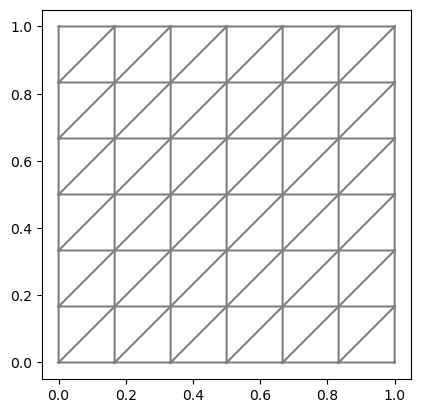

In [5]:
num=6
mesh = RectangleMesh (Point(0, 0), Point(1,1), num, num)
plot(mesh)
print("Setting num :{} // Num Element : {}".format(num, mesh.cells().shape[0]))

In [6]:
num_xy=6
mesh = RectangleMesh ( Point(0, 0), Point(1,1), num_xy, num_xy)

# Define the function spaces:
## Velocity: piecewise quadratic vector.
## Pressure: piecewise linear scalar.
V = VectorElement('CG', triangle, 2)
Q = FiniteElement('CG', triangle, 1)
TH = V * Q
W = FunctionSpace(mesh, TH)

# Define the Dirichlet condition
SlipRate = Expression ( ( "(3.0 + 1.7 * sin ( 2.0 * pi * x[0] ) )", "0.0" ), degree=3 )
def LowerBoundary ( x, on_boundary ):
  return x[1] < DOLFIN_EPS and on_boundary
bc = DirichletBC ( W.sub ( 0 ), SlipRate, LowerBoundary )

#  Define the variational problem
( u, p ) = TrialFunctions ( W )
( v, q ) = TestFunctions ( W )

mu = 0.1
a = ( 0.5 * mu * inner ( grad ( v ) + grad ( v ).T, grad ( u ) + grad ( u ).T ) \
  - div ( v )* p + q * div ( u ) ) * dx

np.random.seed(10)
m0, m1 = np.random.rand(2)
n0, n1, n2, n3 = np.pi*(np.random.rand(4))
f = Expression(('m0*sin(n0*x[0]+n1*x[1])', 'm1*cos(n2*x[0]+n3*x[1])'), degree=5, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
l = inner ( v, f ) * dx

w = Function(W)
solve (a == l, w, bc)

#  Split the mixed solution to recover velocity and pressure.
(u, p) = w.split(deepcopy=True)

sol_u1=torch.tensor(u.sub(0, deepcopy=True).vector()[:])
sol_u2=torch.tensor(u.sub(1,deepcopy=True).vector()[:])
sol_p=torch.tensor(p.vector()[:])
print(torch.min(sol_p),torch.max(sol_p))
print(sol_u1.shape, sol_u2.shape, sol_p.shape)

Solving linear variational problem.
tensor(-2.0482, dtype=torch.float64) tensor(2.1864, dtype=torch.float64)
torch.Size([169]) torch.Size([169]) torch.Size([49])


In [7]:
pos_u=W.sub(0).sub(0).collapse().tabulate_dof_coordinates()
pos_p=W.sub(1).collapse().tabulate_dof_coordinates()

In [8]:
pos_all=W.tabulate_dof_coordinates()
idx_u1=W.sub(0).sub(0).dofmap().dofs()
idx_u2=W.sub(0).sub(1).dofmap().dofs()
idx_p=W.sub(1).dofmap().dofs()

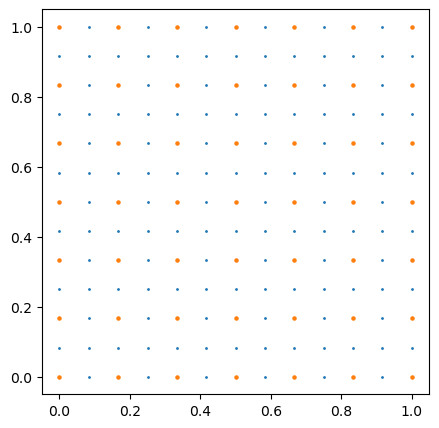

In [9]:
figure=plt.figure(figsize=(5,5))
plt.scatter(pos_u[:,0],pos_u[:,1],s=1)
plt.scatter(pos_p[:,0],pos_p[:,1],s=5)

In [10]:
A = assemble(a)
bc.apply(A)
matrix = A.array()

L = assemble(l)
bc.apply(L)
load_vector = L.get_local()
numerical=np.linalg.solve(matrix,load_vector)

In [11]:
def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k',linewidth=0.1)

In [12]:
import matplotlib.tri as tri
import matplotlib.cm as cm

## **Grid indexing**
### In FEniCS, the solutions sol_u1, sol_u2, and sol_p are computed at positions (x, y) = pos_u, pos_u, pos_p, respectively.

### For the assembled system matrix @ numerical = load_vector, the corresponding positions (x, y) are given by pos_all[idx_u1], pos_all[idx_u2], pos_all[idx_p].

/tmp/ipykernel_2109435/474336136.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(name='terrain')


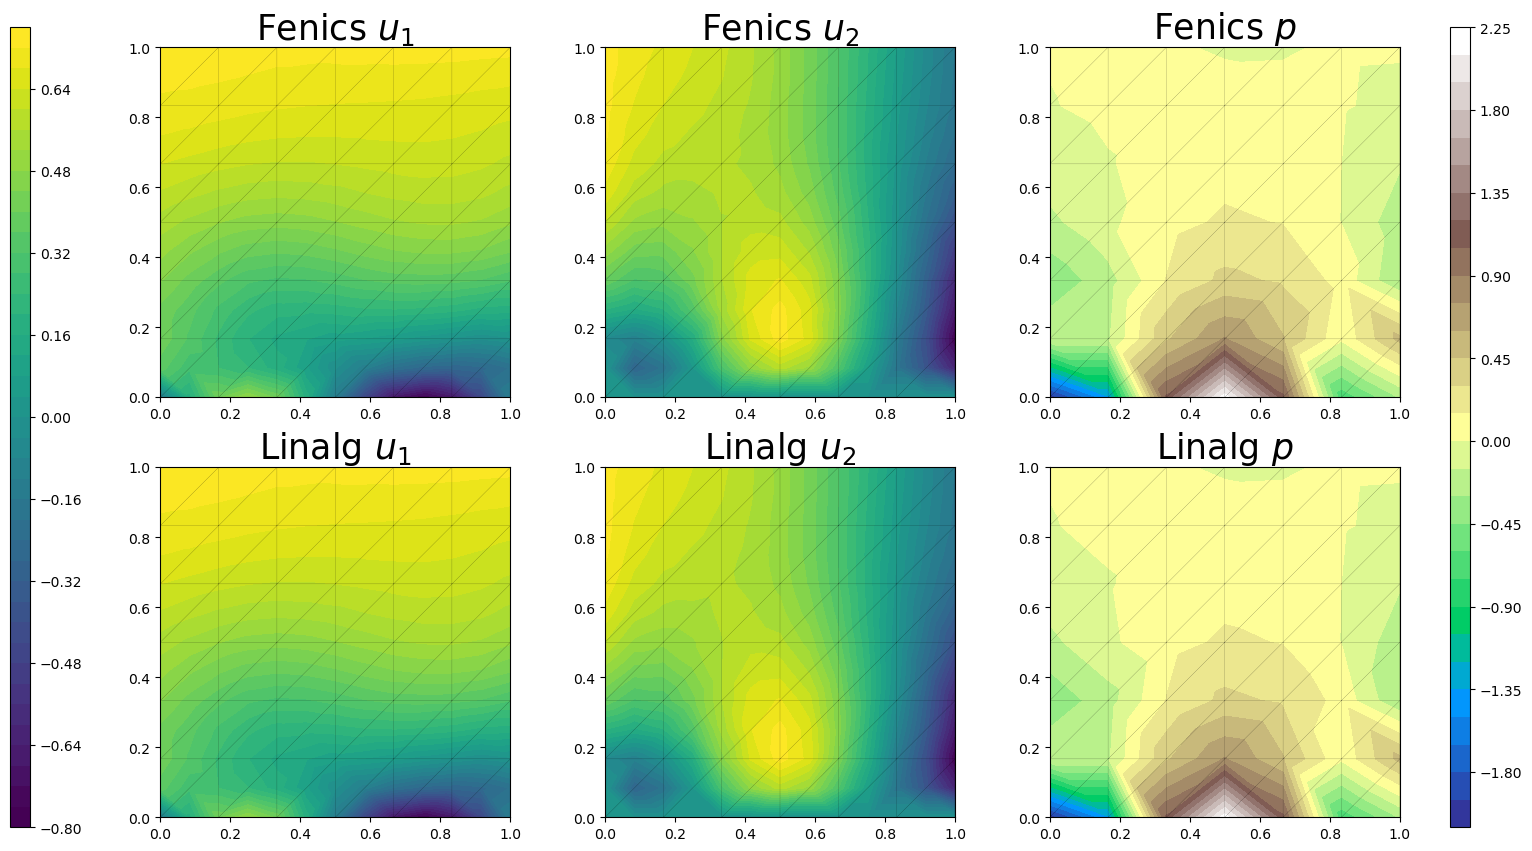

In [14]:
fig=plt.figure(figsize=(20,10))
cmap = cm.get_cmap(name='terrain')
mini_u1, maxi_u1 = min(sol_u1), max(sol_u1)
mini_u2, maxi_u2 = min(sol_u2), max(sol_u2)
mini_p, maxi_p = min(sol_p), max(sol_p)

x=pos_u[:,0]
y=pos_u[:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,1)
ax.set_title(r'Fenics $u_1$',fontsize=25)
im=ax.tricontourf(triang, sol_u1, vmin=mini_u1, vmax=maxi_u1, cmap="viridis", levels=40)
ax.set_aspect(1)
plot(mesh)

ax=plt.subplot(2,3,2)
ax.set_title(r'Fenics $u_2$',fontsize=25)
im=ax.tricontourf(triang, sol_u2, vmin=mini_u2, vmax=maxi_u2, cmap="viridis", levels=40)
ax.set_aspect(1)
plot(mesh)

x=pos_p[:,0]
y=pos_p[:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,3)
ax.set_title(r'Fenics $p$',fontsize=25)
im=ax.tricontourf(triang, sol_p, vmin=mini_p, vmax=maxi_p, cmap='terrain', levels=40)
ax.set_aspect(1)
plot(mesh)



x=pos_all[idx_u1][:,0]
y=pos_all[idx_u1][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,4)
ax.set_title(r'Linalg $u_1$',fontsize=25)
im=ax.tricontourf(triang, numerical[idx_u1], vmin=mini_u1, vmax=maxi_u1, cmap="viridis", levels=40)
ax.set_aspect(1)
plot(mesh)

x=pos_all[idx_u2][:,0]
y=pos_all[idx_u2][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,5)
ax.set_title(r'Linalg $u_2$',fontsize=25)
im=ax.tricontourf(triang, numerical[idx_u2], vmin=mini_u2, vmax=maxi_u2, cmap="viridis", levels=40)
ax.set_aspect(1)
plot(mesh)

fig.subplots_adjust(left=0.2)
cbar_ax = fig.add_axes([0.13, 0.10, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)

x=pos_all[idx_p][:,0]
y=pos_all[idx_p][:,1]
triang = tri.Triangulation(x, y)

ax=plt.subplot(2,3,6)
ax.set_title(r'Linalg $p$',fontsize=25)
im=ax.tricontourf(triang, numerical[idx_p], vmin=mini_p, vmax=maxi_p, cmap='terrain', levels=40)
ax.set_aspect(1)
plot(mesh)

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.10, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax)

In [15]:
def fenics_mesh(num_xy, num_input, deg_f=5):
  mesh = RectangleMesh ( Point(0, 0), Point(1,1), num_xy, num_xy)

  # Define the function spaces:
  ## Velocity: piecewise quadratic vector.
  ## Pressure: piecewise linear scalar.
  V = VectorElement('CG', triangle, 2)
  Q = FiniteElement('CG', triangle, 1)
  TH = V * Q
  W = FunctionSpace(mesh, TH)


  # Define the Dirichlet condition
  SlipRate = Expression ( ( "(3.0 + 1.7 * sin ( 2.0 * pi * x[0] ) )", "0.0" ), degree=3 )
  def LowerBoundary ( x, on_boundary ):
    return x[1] < DOLFIN_EPS and on_boundary
  bc = DirichletBC ( W.sub ( 0 ), SlipRate, LowerBoundary )

  #  Define the variational problem
  ( u, p ) = TrialFunctions ( W )
  ( v, q ) = TestFunctions ( W )

  mu = 0.1
  a = ( 0.5 * mu * inner ( grad ( v ) + grad ( v ).T, grad ( u ) + grad ( u ).T ) \
    - div ( v )* p + q * div ( u ) ) * dx

  A = assemble(a)
  bc.apply(A)
  matrix = A.array()

  train_coeff_fs=[]
  train_load_vectors=[]
  np.random.seed(5)
  for i in tqdm(range(num_input[0])):
    m0, m1 = np.random.rand(2)
    n0, n1, n2, n3 = np.pi*(np.random.rand(4))
    f = Expression(('m0*sin(n0*x[0]+n1*x[1])', 'm1*cos(n2*x[0]+n3*x[1])'), degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
    l = inner(f, v)*dx
    L = assemble(l)
    bc.apply(L)
    load_vector = L.get_local()
    train_coeff_fs.append(np.array([m0, m1, n0, n1, n2, n3]))
    train_load_vectors.append(load_vector)

  validate_coeff_fs=[]
  validate_load_vectors=[]
  np.random.seed(10)
  for i in tqdm(range(num_input[1])):
    m0, m1 = np.random.rand(2)
    n0, n1, n2, n3 = np.pi*(np.random.rand(4))
    f = Expression(('m0*sin(n0*x[0]+n1*x[1])', 'm1*cos(n2*x[0]+n3*x[1])'), degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
    l = inner(f, v)*dx
    L = assemble(l)
    bc.apply(L)
    load_vector = L.get_local()
    validate_coeff_fs.append(np.array([m0, m1, n0, n1, n2, n3]))
    validate_load_vectors.append(load_vector)

  ne=mesh.cells().shape[0]

  pos_all=W.tabulate_dof_coordinates()
  idx_u1=W.sub(0).sub(0).dofmap().dofs()
  idx_u2=W.sub(0).sub(1).dofmap().dofs()
  idx_p=W.sub(1).dofmap().dofs()
  
  p=pos_all
  ng=p.shape[0]


  idx_bdry0_pts=list(bc.get_boundary_values().keys())

  gfl = np.zeros((ng,1))
  gfl[idx_bdry0_pts]=1
  
  idx_sol=[idx_u1,idx_u2,idx_p]
  idx_sol=np.array(idx_sol, dtype=object)
  pos_u=W.sub(0).sub(0).collapse().tabulate_dof_coordinates()
  pos_p=W.sub(1).collapse().tabulate_dof_coordinates()

  print("Num of Elements : {}, Num of points : {}".format(ne, ng))
  return ne, ng, p, gfl, idx_sol, pos_u, pos_p, matrix, np.array(train_coeff_fs), np.array(train_load_vectors), np.array(validate_coeff_fs), np.array(validate_load_vectors)


In [16]:
order='2x1'
list_num_xy=[6,15]
num_input=[1000, 1000]
typ='stokes'

In [17]:
for idx, num in enumerate(list_num_xy):
    ne, ng, p, gfl, idx_sol, pos_u, pos_p, matrix, train_coeff_fs, train_load_vectors, validate_coeff_fs, validate_load_vectors=fenics_mesh(num, num_input)
    np.savez('mesh/P{}_ne{}_{}.npz'.format(order,ne,typ),ne=ne,ng=ng,p=p,gfl=gfl,idx_sol=idx_sol,pos_u=pos_u,pos_p=pos_p,matrix=matrix,train_coeff_fs=train_coeff_fs,train_load_vectors=train_load_vectors, validate_coeff_fs=validate_coeff_fs, validate_load_vectors=validate_load_vectors)

100%|██████████| 1000/1000 [00:00<00:00, 1430.69it/s]


Num of Elements : 72, Num of points : 387


100%|██████████| 1000/1000 [00:01<00:00, 768.84it/s]


Num of Elements : 450, Num of points : 2178


In [18]:
def fenics_data(num_xy, num_input, deg_f=5):
  # Set solver parameters to suppress output
  parameters["std_out_all_processes"] = False  # Suppress output for parallel runs
  set_log_level(LogLevel.ERROR)  # Suppress solver logs
  
  mesh = RectangleMesh ( Point(0, 0), Point(1,1), num_xy, num_xy)
  
  # Define the function spaces:
  ## Velocity: piecewise quadratic vector.
  ## Pressure: piecewise linear scalar.
  V = VectorElement('CG', triangle, 2)
  Q = FiniteElement('CG', triangle, 1)
  TH = V * Q
  W = FunctionSpace(mesh, TH)

  # Define the Dirichlet condition
  SlipRate = Expression ( ( "(3.0 + 1.7 * sin ( 2.0 * pi * x[0] ) )", "0.0" ), degree=3 )
  def LowerBoundary ( x, on_boundary ):
    return x[1] < DOLFIN_EPS and on_boundary
  bc = DirichletBC ( W.sub ( 0 ), SlipRate, LowerBoundary )

  #  Define the variational problem
  ( u, p ) = TrialFunctions ( W )
  ( v, q ) = TestFunctions ( W )

  mu = 0.1
  a = ( 0.5 * mu * inner ( grad ( v ) + grad ( v ).T, grad ( u ) + grad ( u ).T ) \
    - div ( v )* p + q * div ( u ) ) * dx


  # re_idx_pos_u = np.lexsort((pos_u[:,0], pos_u[:,1]))
  # re_idx_pos_p = np.lexsort((pos_p[:,0], pos_p[:,1]))

  train_fenics_u1=[]
  train_fenics_u2=[]
  train_fenics_p=[]
  np.random.seed(5)
  for i in range(num_input[0]):
    m0, m1 = np.random.rand(2)
    n0, n1, n2, n3 = np.pi*(np.random.rand(4))
    f = Expression(('m0*sin(n0*x[0]+n1*x[1])', 'm1*cos(n2*x[0]+n3*x[1])'), degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
    l = inner(f, v)*dx

    w = Function(W)
    solve (a == l, w, bc)
    
    #  Split the mixed solution to recover velocity and pressure.
    (u, p) = w.split(deepcopy=True)
    sol_u1=torch.tensor(u.sub(0, deepcopy=True).vector()[:])
    sol_u2=torch.tensor(u.sub(1,deepcopy=True).vector()[:])
    sol_p=torch.tensor(p.vector()[:])
    
    train_fenics_u1.append(sol_u1)
    train_fenics_u2.append(sol_u2)
    train_fenics_p.append(sol_p)

  validate_fenics_u1=[]
  validate_fenics_u2=[]
  validate_fenics_p=[]
  np.random.seed(10)
  for i in range(num_input[1]):
    m0, m1 = np.random.rand(2)
    n0, n1, n2, n3 = np.pi*(np.random.rand(4))
    f = Expression(('m0*sin(n0*x[0]+n1*x[1])', 'm1*cos(n2*x[0]+n3*x[1])'), degree=deg_f, m0=m0,m1=m1,n0=n0,n1=n1,n2=n2,n3=n3)
    l = inner(f, v)*dx

    w = Function(W)
    solve (a == l, w, bc)
    
    #  Split the mixed solution to recover velocity and pressure.
    (u, p) = w.split(deepcopy=True)
    sol_u1=torch.tensor(u.sub(0, deepcopy=True).vector()[:])
    sol_u2=torch.tensor(u.sub(1,deepcopy=True).vector()[:])
    sol_p=torch.tensor(p.vector()[:])

    validate_fenics_u1.append(sol_u1)
    validate_fenics_u2.append(sol_u2)
    validate_fenics_p.append(sol_p)
  


  return np.array(train_fenics_u1, dtype=object), np.array(train_fenics_u2, dtype=object), np.array(train_fenics_p, dtype=object), np.array(validate_fenics_u1, dtype=object), np.array(validate_fenics_u2, dtype=object), np.array(validate_fenics_p, dtype=object), mesh.cells().shape[0]

In [19]:
order='2x1'
list_num_xy=[15]
num_input=[1000, 1000]
typ='stokes'

In [20]:
import pickle
for idx, num in enumerate(list_num_xy):
      train_fenics_u1,train_fenics_u2,train_fenics_p,validate_fenics_u1,validate_fenics_u2,validate_fenics_p,ne = fenics_data(num, num_input)
      with open('data/train_P{}_{}N{}_{}.pkl'.format(order,num_input[0],ne,typ), 'wb') as f:
            pickle.dump([train_fenics_u1,train_fenics_u2,train_fenics_p], f, pickle.HIGHEST_PROTOCOL)
      with open('data/validate_P{}_{}N{}_{}.pkl'.format(order,num_input[1],ne,typ), 'wb') as f:
            pickle.dump([validate_fenics_u1,validate_fenics_u2,validate_fenics_p], f, pickle.HIGHEST_PROTOCOL)